# Analysing topics of speeches in the German Bundestag

## Get data from BT API

In [94]:
#import libraries
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
BT_protocols=list() # collected documents

parameters = {"apikey": "rgsaY4U.oZRQKUHdJhF9qguHMkwCGIoLaqEcaHjYLF", "f.wahlperiode": 20, "f.zuordnung": "BT", "format": "json"} # parameters for API requests

while 1:
    # get document from API (API only allows retrieval of 10 entities at a time)
    response = requests.get("https://search.dip.bundestag.de/api/v1/plenarprotokoll-text", params=parameters)
    BT_protocols.extend(response.json()["documents"])

    # update cursor for next API request
    if "cursor" in parameters:
        if parameters["cursor"] == response.json()["cursor"]:
            break # exit when cursor position does not change (all documents retrieved)
        else:
            parameters["cursor"] = response.json()["cursor"]
    else:
        parameters["cursor"] = response.json()["cursor"]

# convert to pandas dataframe only retaining relevant features
BT_protocols=pd.DataFrame(BT_protocols)
BT_protocols.reindex(columns=["id", "dokumentnummer","datum","text"])

,id,dokumentnummer,datum,text
0,5585,20/116,2023-07-07,Deutscher Bundestag\nStenografischer Bericht\n...
1,5584,20/115,2023-07-06,Deutscher Bundestag\nStenografischer Bericht\n...
2,5583,20/114,2023-07-05,Deutscher Bundestag\nStenografischer Bericht\n...
3,5582,20/113,2023-06-23,Deutscher Bundestag\nStenografischer Bericht\n...
4,5581,20/112,2023-06-22,Deutscher Bundestag\nStenografischer Bericht\n...
...,...,...,...,...
111,5444,20/5,2021-12-08,[Deutscher Bundestag\nStenografischer Bericht\...
112,5443,20/4,2021-12-07,[Deutscher Bundestag\nStenografischer Bericht\...
113,5435,20/3,2021-11-18,[Deutscher Bundestag\nStenografischer Bericht\...
114,5434,20/2,2021-11-11,[Deutscher Bundestag\nStenografischer Bericht\...


## Preprocessing

In [75]:
#import libraries
import unicodedata
import nltk
import string
import re
from nltk import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/skowron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/skowron/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [76]:
# lower case via the lower() built-in method
docs = [s.lower() for s in BT_protocols["text"]]
docs[0][0:200]

'deutscher bundestag\nstenografischer bericht\n116. sitzung\nberlin, freitag, den 7. juli 2023\ni n h a l t :\nänderung der tagesordnung . . . . . . . . . . . . . . . . . 14311 b\nabsetzung des tagesordnungs'

In [77]:
# remove text before protocol starts and 
docs = [d[d.find("beginn:"):d.rfind("anlagen zum stenografischen bericht")] for d in docs]
print(docs[0][0:50])
print("\n--------------\n")
print(docs[0][-50:])

beginn: 9.00 uhr
präsidentin bärbel bas:
sehr geeh

--------------

die sitzung ist geschlossen.
(schluss: 16.33 uhr)



In [ ]:
#contractions?
# document-specific stop words (names, terms(Beifall))

In [78]:
# clean text
def clean_text(text):
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE) # convert multiple white spaces to single white space
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE) # remove non-ascii characters preserving German special characters, remove digits, remove punctuation
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE) # remove single chars

    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    return text

# apply function
docs = [clean_text(d) for d in docs]
docs[0][0:200]

'beginn uhr präsidentin bärbel bas sehr geehrte damen und herren liebe kolleginnen und kollegen ich wünsche ihnen allen einen wunderschönen guten morgen die sitzung ist eröffnet ich teile ihnen mit das'

In [79]:
#tokenize
tokens = [word_tokenize(d) for d in docs]
tokens[0][0:20]

['beginn',
 'uhr',
 'präsidentin',
 'bärbel',
 'bas',
 'sehr',
 'geehrte',
 'damen',
 'und',
 'herren',
 'liebe',
 'kolleginnen',
 'und',
 'kollegen',
 'ich',
 'wünsche',
 'ihnen',
 'allen',
 'einen',
 'wunderschönen']

In [80]:
# remove stopwords
stop_words = set(stopwords.words("german"))

def remove_stopwords(tokens, stopwords):
    return [t for t in tokens if t not in stopwords]

# apply stopword removal function
tokens = [remove_stopwords(t, stopwords=stop_words) for t in tokens]
tokens[0][0:20]

['beginn',
 'uhr',
 'präsidentin',
 'bärbel',
 'bas',
 'geehrte',
 'damen',
 'herren',
 'liebe',
 'kolleginnen',
 'kollegen',
 'wünsche',
 'wunderschönen',
 'guten',
 'morgen',
 'sitzung',
 'eröffnet',
 'teile',
 'ältestenrat',
 'gestrigen']

In [81]:
#stem words
stemmer = SnowballStemmer("german")

def stem(tokens):
    """stem all tokens that do not contain hyphens"""
    return [stemmer.stem(t) for t in tokens]

# apply function
stems = [stem(t) for t in tokens]
stems[0][0:20]

['beginn',
 'uhr',
 'prasidentin',
 'barbel',
 'bas',
 'geehrt',
 'dam',
 'herr',
 'lieb',
 'kolleginn',
 'kolleg',
 'wunsch',
 'wunderschon',
 'gut',
 'morg',
 'sitzung',
 'eroffnet',
 'teil',
 'altestenrat',
 'gestrig']

In [85]:
# lemmatize with standard spaCy lemmatizer (takes a couple of minutes)
import spacy

nlp_standard = spacy.load('de_core_news_sm')
def lemmatize_sent(sent):
    sent = ' '.join(sent)
    doc = nlp_standard(sent)
    lemmas = [token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in doc]
    return lemmas

# apply function
lemmas = [lemmatize_sent(t) for t in tokens]
lemmas[0][0:20]

['Beginn',
 'Uhr',
 'Präsidentin',
 'Bärbel',
 'Bas',
 'geehrt',
 'Dam',
 'herr',
 'lieb',
 'kolleginn',
 'Kollege',
 'wünsche',
 'wunderschön',
 'Gut',
 'morgen',
 'Sitzung',
 'eröffnen',
 'Teil',
 'ältestenrat',
 'gestrig']

In [90]:
# exclude terms based on tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer

# simple auxiliary function to override the preprocessing done by sklearn
def do_nothing(doc):
    return doc
     
# generate document frequency ranking for all terms in the vocabulary
vectorizer = TfidfVectorizer(use_idf=False, norm=None, tokenizer=do_nothing, preprocessor=do_nothing)
df_matrix = vectorizer.fit_transform(stems).toarray()
df_matrix_bool = np.where(df_matrix > 0, 1, 0)
scores_df = df_matrix_bool.sum(axis=0)

sorted_vocab = sorted(vectorizer.vocabulary_.items(),   key=lambda x: x[1])
sorted_vocab_keys = list(np.array(sorted_vocab)[:,0])
sorted_scores_df = sorted(set(scores_df), reverse=True)

rank_dict = {k:val for k,val in zip(sorted_scores_df, list(range(len(sorted_scores_df))))}
rank_tup = sorted(zip(scores_df, sorted_vocab_keys),  key=lambda x: x[0], reverse=True)
df_ranking = [x + (rank_dict[x[0]],) for x in rank_tup]
df_ranking[:10]

/Users/skowron/opt/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[(116, 'abg', 0),
 (116, 'abgeordnet', 0),
 (116, 'afd', 0),
 (116, 'arbeit', 0),
 (116, 'aufgab', 0),
 (116, 'beginn', 0),
 (116, 'beifall', 0),
 (116, 'beim', 0),
 (116, 'bekannt', 0),
 (116, 'beruf', 0)]

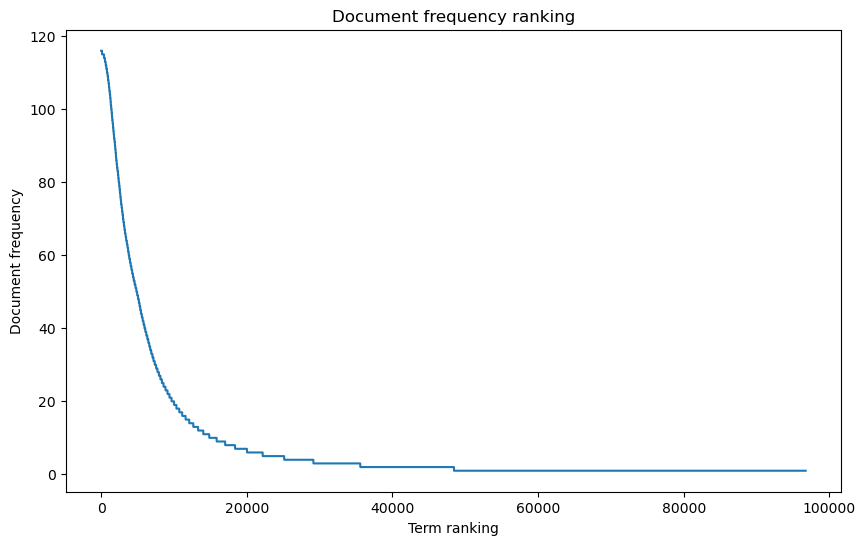

In [95]:
# plot document frequency
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in df_ranking])
plt.title('Document frequency ranking')
plt.ylabel("Document frequency")
plt.xlabel("Term ranking")
plt.show()

In [91]:
# function to compute term-frequency inverse document frequency
def tf_idf_compute(term, num_docs, scores_tf, scores_df):
    return (1+np.log(scores_tf[term])*np.log(num_docs/scores_df[term]))

# generate term frequency inverse document frequency ranking for all terms in the vocabulary
sorted_vocab = sorted(vectorizer.vocabulary_.items(),   key=lambda x: x[1])
sorted_vocab = list(np.array(sorted_vocab)[:,0])
scores_tf = df_matrix.sum(axis=0)
scores_tfidf = [tf_idf_compute(t, len(tokens), scores_tf=scores_tf, scores_df=scores_df) for t in range(len(sorted_vocab))]
sorted_scores_tfidf = sorted(set(scores_tfidf), reverse=True)

rank_dict = {k:val for k,val in zip(sorted_scores_tfidf, list(range(len(sorted_scores_tfidf))))}
rank_tup = sorted(zip(scores_tfidf, sorted_vocab),  key=lambda x: x[0], reverse=True)
tfidf_ranking = [x + (rank_dict[x[0]],) for x in rank_tup]
tfidf_ranking[:10]

[(22.546120490866997, 'wi', 0),
 (20.134872312832027, 'plattduutsch', 1),
 (18.415070705555372, 'imo', 2),
 (18.291593888179616, 'hebb', 3),
 (17.900667671065104, 'nagoya', 4),
 (17.55660841434829, 'weddellme', 5),
 (16.91851328867892, 'ik', 6),
 (16.858381408074383, 'jehovas', 7),
 (16.839934674329236, 'wahlfehl', 8),
 (16.633304918935664, 'progressionsvorbehalt', 9)]

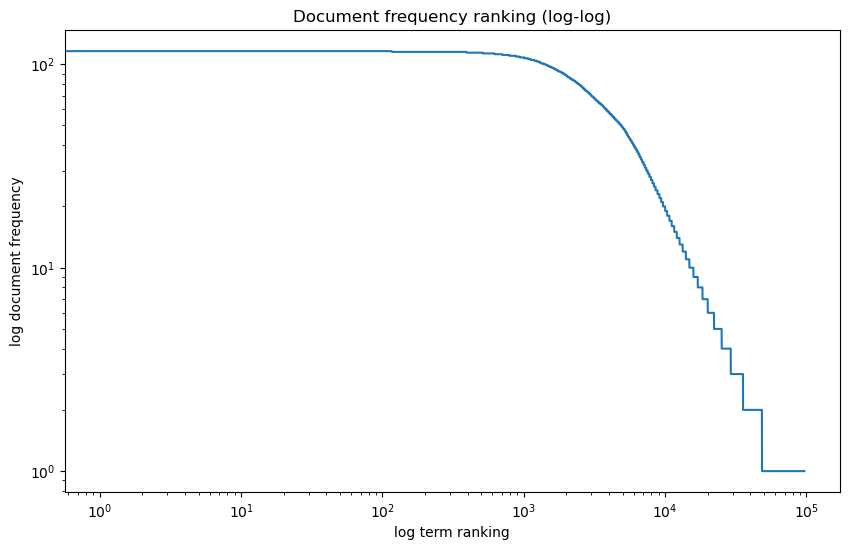

In [97]:
# plot tfidf ranking
plt.figure(figsize=(10,6))
plt.loglog([x[0] for x in df_ranking])
plt.title('Document frequency ranking (log-log)')
plt.ylabel("log document frequency")
plt.xlabel("log term ranking")
plt.show()

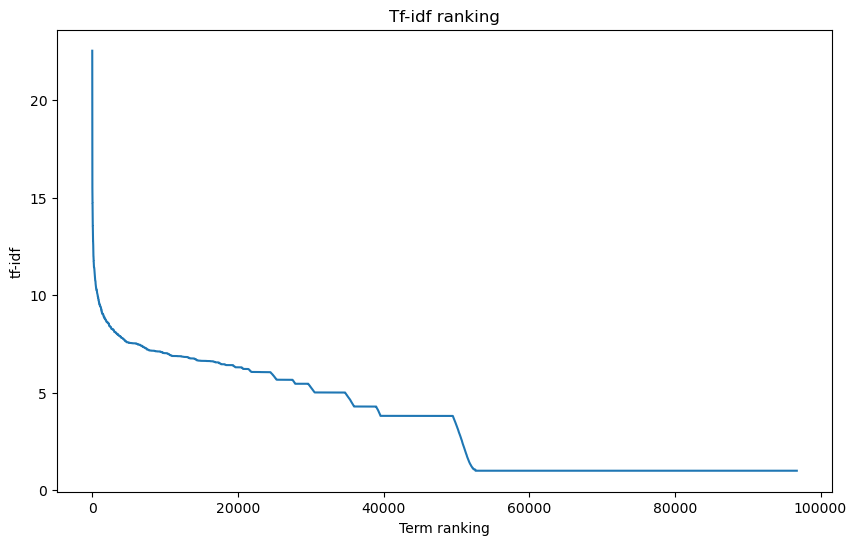

In [98]:
# plot tf-ids ranking
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in tfidf_ranking])
plt.title('Tf-idf ranking')
plt.ylabel("tf-idf")
plt.xlabel("Term ranking")
plt.show()

In [117]:
tfidf_ranking[39000][0]

4.276934646277206

In [152]:
# auxiliary function to easily remove undesired tokens
def remove(tokens, to_remove):
    if to_remove:
        return [t for t in tokens if t not in to_remove]
    else:
        return tokens

# function to remove tokens in documents according to their df or tfidf score
def rank_remove(ranking, docs, min_cutoff_score=-np.inf, max_cutoff_score=np.inf):

    # define list of tokens to remove
    to_remove_low = set([t[1] for t in ranking if t[0] <= min_cutoff_score])
    to_remove_high = set([t[1] for t in ranking if t[0] > max_cutoff_score])

    # remove tokens
    docs_clean = [remove(d, to_remove_low) for d in docs]
    docs_clean = [remove(d, to_remove_high) for d in docs_clean]

    return docs_clean
     
# update documents
stems_clean = rank_remove(tfidf_ranking, stems, min_cutoff_score=tfidf_ranking[39000][0])

In [167]:
#create document-term matrix with selected stems
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(preprocessor=do_nothing,              # apply no additional preprocessing
                                   tokenizer=do_nothing,                 # apply no additional tokenization
                                   lowercase=False,                      # convert all characters to lower-case
                                   strip_accents=None,                   # remove non-ascii characters
                                   stop_words=None,                      # remove stopwords from a built-in list. We can also provide our own list
                                   ngram_range=(1, 1),                   # generate only unigrams
                                   analyzer='word',                      # analysis at the word-level
                                   max_df=1.0,                           # ignore tokens that have a higher document frequency (can be int or percent)
                                   min_df=0,                             # ignore tokens that have a lowe document frequency (can be int or percent)
                                   max_features=None,                    # we could impose a maximum number of vocabulary terms
                                   )

# create the document term matrix using stems
dt_matrix_stems = count_vectorizer.fit_transform(stems_clean).toarray()
print(dt_matrix_stems.shape)
print(dt_matrix_stems.dtype)
word2idx = count_vectorizer.vocabulary_
idx2word = {i:word for word,i in word2idx.items()}


/Users/skowron/opt/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(116, 38999)
int64


## Fit topic model (LDA)

In [ ]:
# create LDA object with our parameters
import lda

num_topics = 30
vocab_size = dt_matrix_stems.shape[1]
lda_model = lda.LDA(n_topics=num_topics,         # Number of topics
                    alpha=50/num_topics,         # Dirichlet parameter for distribution over topics
                    eta=200/vocab_size,          # Dirichlet parameter for distribution over words
                    n_iter=5000,                 # Number of sampling iterations
                    random_state=92              # The generator used for the initial topics
                    )



# check some paramters
print(lda_model.alpha)
print(lda_model.eta)
print(lda_model.n_topics)

NameError: name 'lda' is not defined

In [ ]:
tickdates=pd.DataFrame(["2022-01-01" "2022-07-01" "2023-01-01"])